# Sentiment Analysis

#### Importing useful libraries

In [82]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplcursors
import plotly.express as px
from datetime import datetime

#NLP libraries 
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob

import yfinance as yf

from scipy import stats as stat

#### Dataset import

In [83]:
# Replace file path with the personal one in which the dataset is contained
chunk = pd.read_csv("/Users/eliacannas/Desktop/SentimentAnalysis/venv/Bitcoin_tweets.csv", chunksize=100000,lineterminator='\n', low_memory=False)
df = pd.concat(chunk)

df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4689354 entries, 0 to 4689353
Data columns (total 13 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_name         object
 1   user_location     object
 2   user_description  object
 3   user_created      object
 4   user_followers    object
 5   user_friends      object
 6   user_favourites   object
 7   user_verified     object
 8   date              object
 9   text              object
 10  hashtags          object
 11  source            object
 12  is_retweet        object
dtypes: object(13)
memory usage: 465.1+ MB


(4689354, 13)

In [84]:
# we assiacure that there are no cells with null values in the date and text columns
df.dropna(axis=0 ,subset=['date','text'],inplace = True)
df.reset_index(drop= True,inplace=True)
df.shape

(4689354, 13)

In [85]:
# Data cleaning 
df.drop_duplicates(inplace = True)
df.reset_index(drop=True,inplace=True)
df.shape

(4689354, 13)

In [86]:
# Setting dataset column types
df = df.convert_dtypes()
df.dtypes

user_name           string[python]
user_location       string[python]
user_description    string[python]
user_created        string[python]
user_followers              object
user_friends                object
user_favourites             object
user_verified               object
date                string[python]
text                string[python]
hashtags            string[python]
source              string[python]
is_retweet                 boolean
dtype: object

In [87]:
# Check which of the rows don't have an actuall date in the 'date' column
def validate(date_text):
    errors = []
    for i,v in enumerate(date_text):
        try:
            datetime.strptime(v, '%Y-%m-%d %H:%M:%S')
        except ValueError:
            errors.append(i)
    return errors

In [88]:
# Print number of date not valid
errors = validate(df['date'])
print('There are '+ str(len(errors)) + ' values that are not actual dates in the date column')

There are 66 values that are not actual dates in the date column


In [89]:
 # Removal of rows containing an invalid date
df_date_clean = df.loc[~df.index.isin(errors)]
df_date_clean.reset_index(drop=True,inplace=True)
df_date_clean.shape

(4689288, 13)

#### Print first and last tweet dates

In [90]:
# First and last tweet in time order
# Sort the DataFrame by the 'date' column
df_date_clean = df_date_clean.sort_values(by='date')

# Get the first and last tweet
primo_tweet = df_date_clean.iloc[0]
ultimo_tweet = df_date_clean.iloc[-1]

# Print the results
print("First tweet:")
print(primo_tweet['date'])

print("\nLast tweet:")
print(ultimo_tweet['date'])

First tweet:
2021-02-05 10:52:04

Last tweet:
2023-01-09 23:59:54


In [91]:
# we use tweets from January 9, 2022 to January 9, 2023
df_date_clean['date'] = pd.to_datetime(df_date_clean['date'], format='%Y-%m-%d %H:%M:%S')

In [92]:
df_date_clean_final = df_date_clean.loc[(df_date_clean['date'] >= '2022-01-09')].reset_index(drop=True)
df_date_clean_final.shape

(2689765, 13)

#### Hashtags List

In [93]:
# Make sure the 'hashtags' column is of type string
df_date_clean_final['hashtags'] = df_date_clean_final['hashtags'].astype(str)

# Create a list of all hashtags
all_hashtags = []
for hashtags_str in df_date_clean_final['hashtags']:
    # Remove unwanted characters and split to get list of hashtags
    hashtags = [tag.strip("[]'") for tag in hashtags_str.split(', ')]
    all_hashtags.extend(hashtags)

# Remove any special characters from the hashtags
all_hashtags = [tag.strip("#") for tag in all_hashtags]

# Count the frequency of hashtags
hashtags_frequenza = pd.Series(all_hashtags).value_counts()

# View the N most influential hashtags (10)
numero_hashtags_influenti = 10
hashtags_influenti = hashtags_frequenza.head(numero_hashtags_influenti)

# Print the most influential hashtags
print("The most influential hashtags in the dataset:")
print(hashtags_influenti)

The most influential hashtags in the dataset:
Bitcoin           1230867
BTC               1149722
bitcoin            551533
btc                420829
ETH                415033
crypto             397353
cryptocurrency     384491
Crypto             308560
Ethereum           251056
NFT                201342
Name: count, dtype: int64


In [94]:
# Removing Unicode Characters
df_date_clean_final['text'] = df_date_clean_final['text'].str.replace("(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"," ")
df_clean = df_date_clean_final.copy()
df_clean.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,NFT Nomad 💎,<NA>,NFT Creator: https://t.co/gz5OlavMCa,2021-11-24 07:08:31,65.0,64.0,111.0,False,2022-01-11 17:11:49,$LNR is going to be huge!!!! Kucoin and bitmar...,"['Ethereum', 'crypto', 'cryptocurrency', 'nft'...",Twitter for Android,False
1,Digital Shogun ပωပ 🛡🌐⚔,Rings of Saturn,Non-Binary🏳️‍🌈Metaverse Builder. Web3 Content ...,2021-01-19 10:54:08,4082.0,221.0,59613.0,False,2022-01-11 17:11:49,"Another decent bounce for #Bitcoin $BTC 1w, 1...","['Bitcoin', 'HODL']",Twitter for Android,False
2,Conor Okus,Global,Making #Bitcoin more than an investment @spira...,2012-01-16 20:55:11,3771.0,439.0,11363.0,False,2022-01-11 17:11:49,Heads up! I'll be going live this Thursday at ...,['Bitcoin'],Twitter Web App,False
3,Kyptos.com,<NA>,https://t.co/d03RricqLo - Latest News About Cr...,2021-09-20 02:40:53,10330.0,217.0,36.0,False,2022-01-11 17:11:50,Will LUNA Price Bounce Again at .382 Fibonacci...,"['bitcoin', 'ElSalvador', 'metaverse', 'NFTs',...",IFTTT,False
4,Dr. Crypto Jones,"Atlanta, GA",I am NOT a financial advisor. I AM a cryptocur...,2021-03-21 01:27:11,19.0,109.0,132.0,False,2022-01-11 17:11:51,"Not too much, but 2022 be good to me baby! Bin...","['NFT', 'Ethereum', 'Bitcoin']",Twitter for Android,False


In [95]:
import ssl

# Disable SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

# Download Punkt tokenizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/eliacannas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [96]:
# Tokenization
df_clean['text'] = df_clean.apply(lambda row: word_tokenize(row['text']), axis=1)
df_clean.head()


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,NFT Nomad 💎,<NA>,NFT Creator: https://t.co/gz5OlavMCa,2021-11-24 07:08:31,65.0,64.0,111.0,False,2022-01-11 17:11:49,"[$, LNR, is, going, to, be, huge, !, !, !, !, ...","['Ethereum', 'crypto', 'cryptocurrency', 'nft'...",Twitter for Android,False
1,Digital Shogun ပωပ 🛡🌐⚔,Rings of Saturn,Non-Binary🏳️‍🌈Metaverse Builder. Web3 Content ...,2021-01-19 10:54:08,4082.0,221.0,59613.0,False,2022-01-11 17:11:49,"[Another, decent, bounce, for, #, Bitcoin, $, ...","['Bitcoin', 'HODL']",Twitter for Android,False
2,Conor Okus,Global,Making #Bitcoin more than an investment @spira...,2012-01-16 20:55:11,3771.0,439.0,11363.0,False,2022-01-11 17:11:49,"[Heads, up, !, I, 'll, be, going, live, this, ...",['Bitcoin'],Twitter Web App,False
3,Kyptos.com,<NA>,https://t.co/d03RricqLo - Latest News About Cr...,2021-09-20 02:40:53,10330.0,217.0,36.0,False,2022-01-11 17:11:50,"[Will, LUNA, Price, Bounce, Again, at, .382, F...","['bitcoin', 'ElSalvador', 'metaverse', 'NFTs',...",IFTTT,False
4,Dr. Crypto Jones,"Atlanta, GA",I am NOT a financial advisor. I AM a cryptocur...,2021-03-21 01:27:11,19.0,109.0,132.0,False,2022-01-11 17:11:51,"[Not, too, much, ,, but, 2022, be, good, to, m...","['NFT', 'Ethereum', 'Bitcoin']",Twitter for Android,False


In [97]:
# Disable SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

# Download Punkt tokenizer stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eliacannas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [98]:
# Removing Stopwords
stop_words = set(stopwords.words('english'))
df_clean['text'] = df_clean.apply(lambda row: (" ".join([word for word in row['text'] if word not in stop_words])),axis=1)

#### Sentiment Analysis

In [99]:
# Sentiment analysis 
df_clean[['polarity', 'subjectivity']] = df_clean['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
df_clean.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,polarity,subjectivity
0,NFT Nomad 💎,<NA>,NFT Creator: https://t.co/gz5OlavMCa,2021-11-24 07:08:31,65.0,64.0,111.0,False,2022-01-11 17:11:49,$ LNR going huge ! ! ! ! Kucoin bitmart listin...,"['Ethereum', 'crypto', 'cryptocurrency', 'nft'...",Twitter for Android,False,0.550000,0.650000
1,Digital Shogun ပωပ 🛡🌐⚔,Rings of Saturn,Non-Binary🏳️‍🌈Metaverse Builder. Web3 Content ...,2021-01-19 10:54:08,4082.0,221.0,59613.0,False,2022-01-11 17:11:49,"Another decent bounce # Bitcoin $ BTC 1w , 1d ...","['Bitcoin', 'HODL']",Twitter for Android,False,0.222222,0.518519
2,Conor Okus,Global,Making #Bitcoin more than an investment @spira...,2012-01-16 20:55:11,3771.0,439.0,11363.0,False,2022-01-11 17:11:49,Heads ! I 'll going live Thursday 18:30 UTC @ ...,['Bitcoin'],Twitter Web App,False,0.568182,0.400000
3,Kyptos.com,<NA>,https://t.co/d03RricqLo - Latest News About Cr...,2021-09-20 02:40:53,10330.0,217.0,36.0,False,2022-01-11 17:11:50,Will LUNA Price Bounce Again .382 Fibonacci Re...,"['bitcoin', 'ElSalvador', 'metaverse', 'NFTs',...",IFTTT,False,0.000000,0.000000
4,Dr. Crypto Jones,"Atlanta, GA",I am NOT a financial advisor. I AM a cryptocur...,2021-03-21 01:27:11,19.0,109.0,132.0,False,2022-01-11 17:11:51,"Not much , 2022 good baby ! Bing bong ! # NFT ...","['NFT', 'Ethereum', 'Bitcoin']",Twitter for Android,False,0.450000,0.400000


In [100]:
# Rename df
df_sentiment = df_clean.copy()

In [101]:
# Assigning positive, negative or neutral value based on polarity, creating new column in dataset 'Sentiment' and removing unnecessary columns
df_sentiment['Sentiment'] = df_sentiment["polarity"].apply(lambda x: "Positive" if x > 0 else( "Negative" if x < 0  else "Neutral"))
df_sentiment.drop(['user_description','user_created','source','subjectivity'],axis=1,inplace=True)
df_sentiment.head()

,user_name,user_location,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,is_retweet,polarity,Sentiment
0,NFT Nomad 💎,<NA>,65.0,64.0,111.0,False,2022-01-11 17:11:49,$ LNR going huge ! ! ! ! Kucoin bitmart listin...,"['Ethereum', 'crypto', 'cryptocurrency', 'nft'...",False,0.550000,Positive
1,Digital Shogun ပωပ 🛡🌐⚔,Rings of Saturn,4082.0,221.0,59613.0,False,2022-01-11 17:11:49,"Another decent bounce # Bitcoin $ BTC 1w , 1d ...","['Bitcoin', 'HODL']",False,0.222222,Positive
2,Conor Okus,Global,3771.0,439.0,11363.0,False,2022-01-11 17:11:49,Heads ! I 'll going live Thursday 18:30 UTC @ ...,['Bitcoin'],False,0.568182,Positive
3,Kyptos.com,<NA>,10330.0,217.0,36.0,False,2022-01-11 17:11:50,Will LUNA Price Bounce Again .382 Fibonacci Re...,"['bitcoin', 'ElSalvador', 'metaverse', 'NFTs',...",False,0.000000,Neutral
4,Dr. Crypto Jones,"Atlanta, GA",19.0,109.0,132.0,False,2022-01-11 17:11:51,"Not much , 2022 good baby ! Bing bong ! # NFT ...","['NFT', 'Ethereum', 'Bitcoin']",False,0.450000,Positive


In [102]:
# String formatting
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'], format='%Y-%m-%d %H:%M:%S')
df_sentiment.shape

(2689765, 12)

In [103]:
# Use only date without time
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'], format='%Y-%m-%d %H:%M:%S').dt.date
df_sentiment.head()
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2689765 entries, 0 to 2689764
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   user_name        string 
 1   user_location    string 
 2   user_followers   object 
 3   user_friends     object 
 4   user_favourites  object 
 5   user_verified    object 
 6   date             object 
 7   text             object 
 8   hashtags         object 
 9   is_retweet       boolean
 10  polarity         float64
 11  Sentiment        object 
dtypes: boolean(1), float64(1), object(8), string(2)
memory usage: 230.9+ MB


In [104]:
# Filter the DataFrame for dates between March and June 2022
start_date = pd.to_datetime('2022-03-01').date() # Date to start
end_date = pd.to_datetime('2022-06-30').date() # Date to finish 
df_filtered = df_sentiment.loc[(df_sentiment['date'] >= start_date) & (df_sentiment['date'] <= end_date)].reset_index(drop=True)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1479443 entries, 0 to 1479442
Data columns (total 12 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   user_name        1479433 non-null  string 
 1   user_location    716554 non-null   string 
 2   user_followers   1479443 non-null  object 
 3   user_friends     1479443 non-null  object 
 4   user_favourites  1479443 non-null  object 
 5   user_verified    1479443 non-null  object 
 6   date             1479443 non-null  object 
 7   text             1479443 non-null  object 
 8   hashtags         1479443 non-null  object 
 9   is_retweet       1479409 non-null  boolean
 10  polarity         1479443 non-null  float64
 11  Sentiment        1479443 non-null  object 
dtypes: boolean(1), float64(1), object(8), string(2)
memory usage: 127.0+ MB


In [105]:
# Group by date and Sentiment and count the number of tweets for each combination
grouped_data = df_filtered.groupby(['date', 'Sentiment']).size().reset_index(name='tweet_count')
print(grouped_data)

           date Sentiment  tweet_count
0    2022-03-02  Negative          959
1    2022-03-02   Neutral         3464
2    2022-03-02  Positive         3951
3    2022-03-06  Negative          842
4    2022-03-06   Neutral         3625
..          ...       ...          ...
181  2022-06-28   Neutral         4981
182  2022-06-28  Positive         3362
183  2022-06-29  Negative         4615
184  2022-06-29   Neutral        19488
185  2022-06-29  Positive        14644

[186 rows x 3 columns]


### Graphic display of results

In [106]:
# Create a pivot table to get the right format for the histogram
pivot_table = grouped_data.pivot(index='date', columns='Sentiment', values='tweet_count').fillna(0)

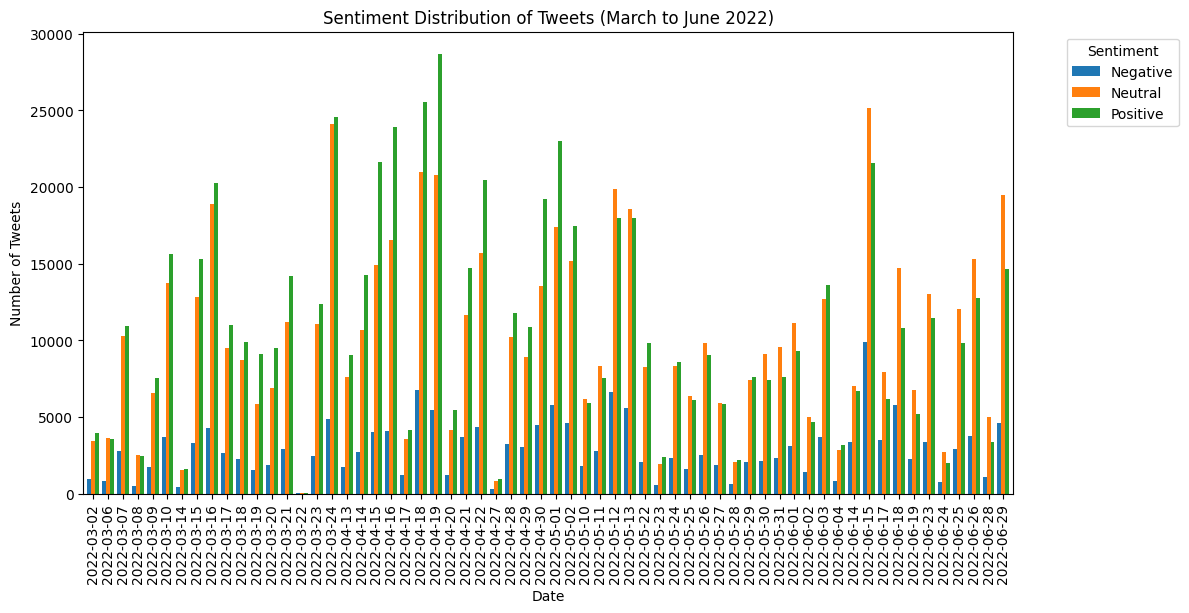

In [107]:
# Draw histogram with grouped bars
fig, ax = plt.subplots(figsize=(12, 6))
pivot_table.plot(kind='bar', ax=ax, width=0.8)

# Set title and axis labels
plt.title('Sentiment Distribution of Tweets (March to June 2022)')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')

# Show legend
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show graph
plt.show()

In [108]:
# Assuming your DataFrame is called df and contains the attribute "Sentiment"
sentiment_counts = df_filtered['Sentiment'].value_counts()

# Calculate the percentage
sentiment_percentages = (sentiment_counts / len(df_filtered)) * 100

# Print the results
print("Percentage of Sentiment:")
print(sentiment_percentages)

Percentage of Sentiment:
Sentiment
Positive    45.589658
Neutral     42.313763
Negative    12.096580
Name: count, dtype: float64


In [109]:
# BTC data over the period indicated
btc_stock = yf.Ticker("BTC-USD")
start = pd.to_datetime('2022-03-01').date()
end = pd.to_datetime('2022-06-30').date()
btc_data = btc_stock.history(start=start, end=end)

/Users/eliacannas/Desktop/SentimentAnalysis/venv/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


#### Daily closing bitcoin price trend in closing

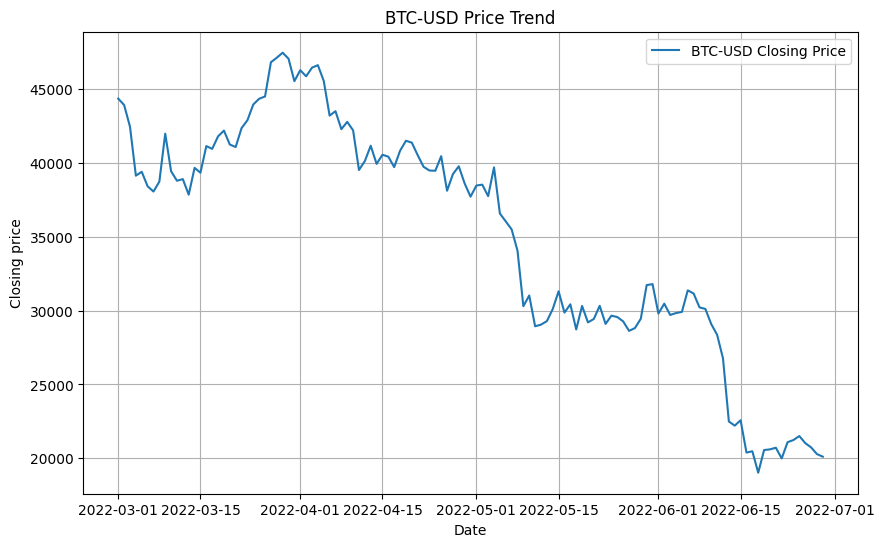

In [110]:
# View the graph of the price trend
plt.figure(figsize=(10, 6))
plt.plot(btc_date['Close'], label='BTC-USD Closing Price')
plt.title('BTC-USD Price Trend')
plt.xlabel('Date')
plt.ylabel('Closing price')
plt.legend()
plt.grid(True)
plt.show()

In [111]:
# Creation of 3 different datasets
df_positive=df_filtered.loc[df_filtered.Sentiment=="Positive"]
df_negative=df_filtered.loc[df_filtered.Sentiment=="Negative"]
df_neutral=df_filtered.loc[df_filtered.Sentiment=="Neutral"]

In [112]:
# Grouping negative tweets by date and count them
tweets_vol_negative = df_negative.groupby('date').size().reset_index(name='tweet_count')
print(tweets_vol_negative)
# Removal time from date
tweets_vol_negative['date'] = pd.to_datetime(tweets_vol_negative['date'], format='%Y-%m-%d %H:%M:%S').dt.date
tweets_vol_negative.info()

          date  tweet_count
0   2022-03-02          959
1   2022-03-06          842
2   2022-03-07         2792
3   2022-03-08          499
4   2022-03-09         1752
..         ...          ...
57  2022-06-24          733
58  2022-06-25         2933
59  2022-06-26         3783
60  2022-06-28         1101
61  2022-06-29         4615

[62 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         62 non-null     object
 1   tweet_count  62 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


#### Graph showing the correlation of bitcoin price trend with negative tweets

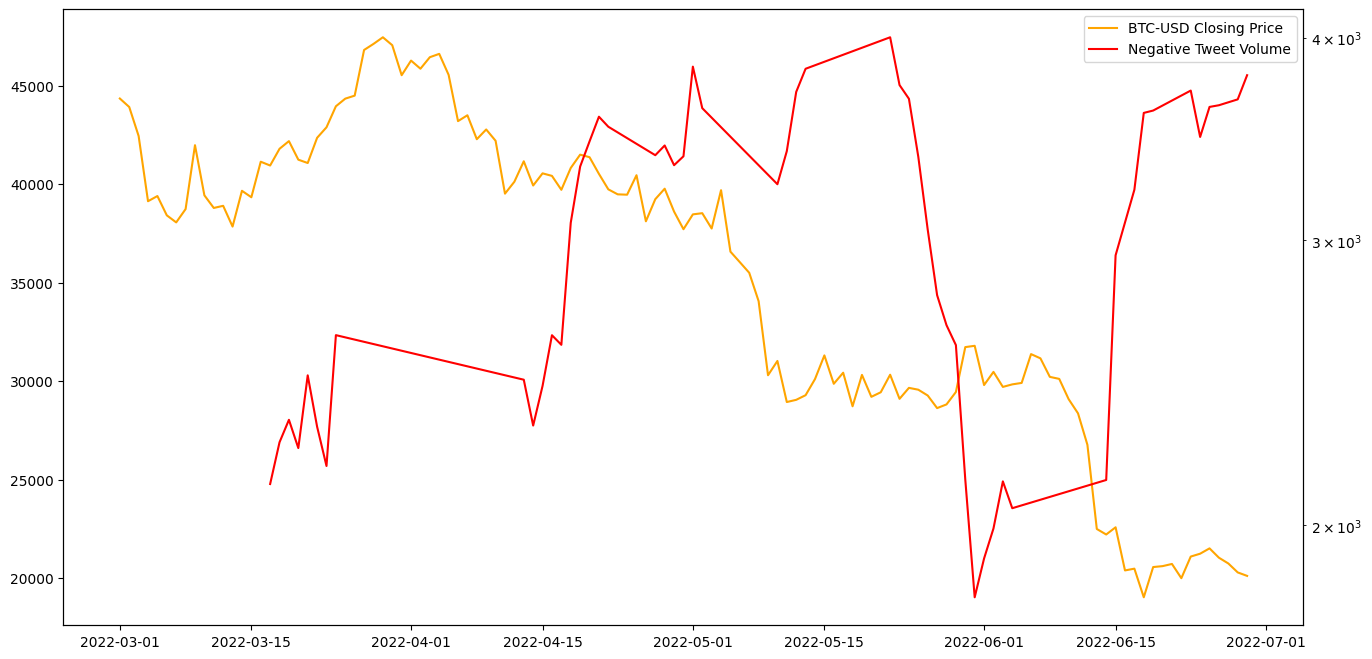

In [113]:
# Calculation of a 10-period moving average of the volume of negative tweets grouped by date.
tweets_vol_negative = df_negative.groupby('date').size().rolling(10).mean()

# Graph creation
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(btc_data.index, btc_data['Close'], label='BTC-USD Closing Price', color="orange")

ax2 = ax.twinx()
ax2.plot(tweets_vol_negative.index, tweets_vol_negative, label='Negative Tweet Volume', color="red")
ax2.set_yscale('log')

# Get the labels and lines for the legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.show()

#### We can identify two periods in which there is a strong inverse correlation between the price of bitcoin and the volume of negative tweets, the periods are 11-05 through 14-05 and 14-06 through 17-06